In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import corner
import emcee

import astropy.io.fits as fits


In [3]:
filename = 'outerdisk_sample.fits'
hdu = fits.open(filename)
hdu.info()
hdu[1].header
print(hdu[1].data.names)
print(hdu[1].data.field('teff_err'))


Filename: outerdisk_sample.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (10006,)   uint8   
  1  Joined        1 BinTableHDU     75   23983R x 18C   [E, E, E, E, E, E, D, D, D, D, D, D, D, D, D, D, D, L]   
['teff', 'teff_err', 'feh', 'feh_err', 'rv', 'rv_err', 'glon', 'glat', 'distK50_RJCE', 'distK15_RJCE', 'distK85_RJCE', 'X', 'Y', 'Z', 'Rgc', 'r_gc', 'PHI', 'Kgiant_noRC_noDup']
[151.72 148.29 228.11 ... 143.03  82.58 173.9 ]


In [26]:
#数据处理
y=hdu[1].data.field('feh')
dv=hdu[1].data.field('feh_err')
r=hdu[1].data.field('rgc')
r=np.where(r<40,r,np.nan)
nansy = np.isnan(y)
nansdv = np.isnan(dv)
nansr = np.isnan(r)
print(np.where(nansr))
y = np.delete(y, np.where(nansr))
dv= np.delete(dv, np.where(nansr))
r= np.delete(r, np.where(nansr))
nansr = np.isnan(r)
print(np.where(nansr))
print(np.max(y))

(array([  349,   357,   385,   412,   782,   825,   829,   859,   919,
         922,  1429,  1435,  1439,  1444,  1481,  1482,  1483,  1485,
        1491,  1492,  1494,  1498,  1535,  1605,  1664,  1680,  1711,
        1853,  1912,  1933,  1935,  1960,  1967,  1975,  2005,  2072,
        2147,  2197,  2222,  2274,  2282,  2491,  2624,  2751,  2905,
        3010,  3119,  3230,  3251,  3300,  3306,  3309,  3483,  3527,
        3529,  3535,  3808,  4265,  4318,  4579,  4597,  4738,  4830,
        4871,  4876,  4926,  5106,  5113,  5245,  5327,  5382,  5522,
        5533,  5723,  5766,  5785,  5789,  5885,  5986,  6059,  6072,
        6143,  6170,  6178,  6193,  6207,  6509,  6536,  6585,  6641,
        6680,  6730,  6809,  6890,  6982,  6985,  6996,  7013,  7041,
        7245,  7255,  7267,  7322,  7405,  7429,  7458,  7476,  7484,
        7490,  7517,  7547,  7585,  7637,  7711,  7721,  7799,  7812,
        8050,  8206,  8314,  8386,  8439,  8513,  8527,  8633,  8639,
        8651,  8700

In [27]:
# 后验分布
def postrior(x,y,r,dv):#x是梯度值，y是铁氢度，dv是误差
    d=x[0]
    d0=x[1]
    re=abs((r-8.34)*0.2)
    vv=d*r+d0
    dvv=abs(d*re)
    print(dvv)
    der = stats.norm.rvs(loc=vv, scale=dvv, size=len(r))
    L=np.sum((-(y-der)**2)/(2*dv**2)-0.5*np.log(2.*np.pi)-np.log(dv))
    return L


[0.01712907 0.10279232 0.03676454 ... 0.18970277 0.06355495 0.07400983]
[0.09925477 0.59563221 0.2130329  ... 1.09923668 0.3682705  0.4288515 ]
[0.13701054 0.82220623 0.29406902 ... 1.51737805 0.50835784 0.59198339]
[0.04363768 0.26187162 0.0936606  ... 0.48328295 0.16191131 0.18854594]
[0.07707949 0.46255737 0.16543756 ... 0.85364763 0.28599232 0.33303844]
[0.05397037 0.32387856 0.11583791 ... 0.59771649 0.20024928 0.23319056]
[0.08586826 0.5152992  0.18430112 ... 0.95098245 0.3186018  0.37101223]
[0.09759526 0.58567344 0.20947106 ... 1.08085781 0.36211314 0.42168125]
[0.12973025 0.77851694 0.27844317 ... 1.43674966 0.4813454  0.56052737]
[0.09657953 0.579578   0.20729097 ... 1.06960869 0.35834442 0.41729256]
[0.12319811 0.73931723 0.26442306 ... 1.36440675 0.4571088  0.53230382]
[0.14531168 0.87202177 0.31188596 ... 1.60931241 0.53915804 0.62785027]
[0.03590077 0.21544211 0.07705469 ... 0.39759749 0.13320464 0.15511698]
[0.12109395 0.72669013 0.25990687 ... 1.34110349 0.44930166 0.52

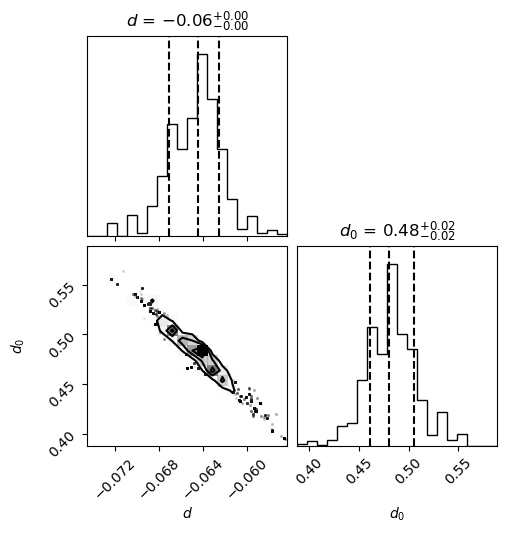

In [28]:
nwalker = 50
ndim = 2
p0 = np.zeros((nwalker,ndim))
p0[:,0] = np.random.rand(nwalker)
p0[:,1] = np.random.rand(nwalker)
sampler = emcee.EnsembleSampler(nwalker, ndim, postrior,args=[y,r,dv])
pos,prob,stat = sampler.run_mcmc(p0,100)
sampler.reset()
sampler.run_mcmc(pos,1000)
samples = sampler.chain[:, :, :].reshape((-1, ndim))
fig = corner.corner(samples,\
    labels=[r'$d$',r'$d_0$'],\
        quantiles=[0.16, 0.5, 0.84],\
        show_titles=True, \
        title_kwargs={"fontsize": 12})